In [ ]:
pip install -r requirements.txt

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest

[0]	validation_0-rmse:5.26503
[1]	validation_0-rmse:5.13277
[2]	validation_0-rmse:5.01625
[3]	validation_0-rmse:4.92395
[4]	validation_0-rmse:4.77725
[5]	validation_0-rmse:4.69039
[6]	validation_0-rmse:4.60634
[7]	validation_0-rmse:4.50719
[8]	validation_0-rmse:4.41892
[9]	validation_0-rmse:4.35023
[10]	validation_0-rmse:4.24756
[11]	validation_0-rmse:4.17650
[12]	validation_0-rmse:4.12112
[13]	validation_0-rmse:4.05712
[14]	validation_0-rmse:4.00731
[15]	validation_0-rmse:3.93000
[16]	validation_0-rmse:3.89160
[17]	validation_0-rmse:3.82821
[18]	validation_0-rmse:3.77068
[19]	validation_0-rmse:3.72549
[20]	validation_0-rmse:3.66412
[21]	validation_0-rmse:3.62368
[22]	validation_0-rmse:3.56008
[23]	validation_0-rmse:3.52523
[24]	validation_0-rmse:3.48354
[25]	validation_0-rmse:3.43096
[26]	validation_0-rmse:3.38686
[27]	validation_0-rmse:3.36673
[28]	validation_0-rmse:3.33652
[29]	validation_0-rmse:3.31324
[30]	validation_0-rmse:3.29145
[31]	validation_0-rmse:3.26669
[32]	validation_0-

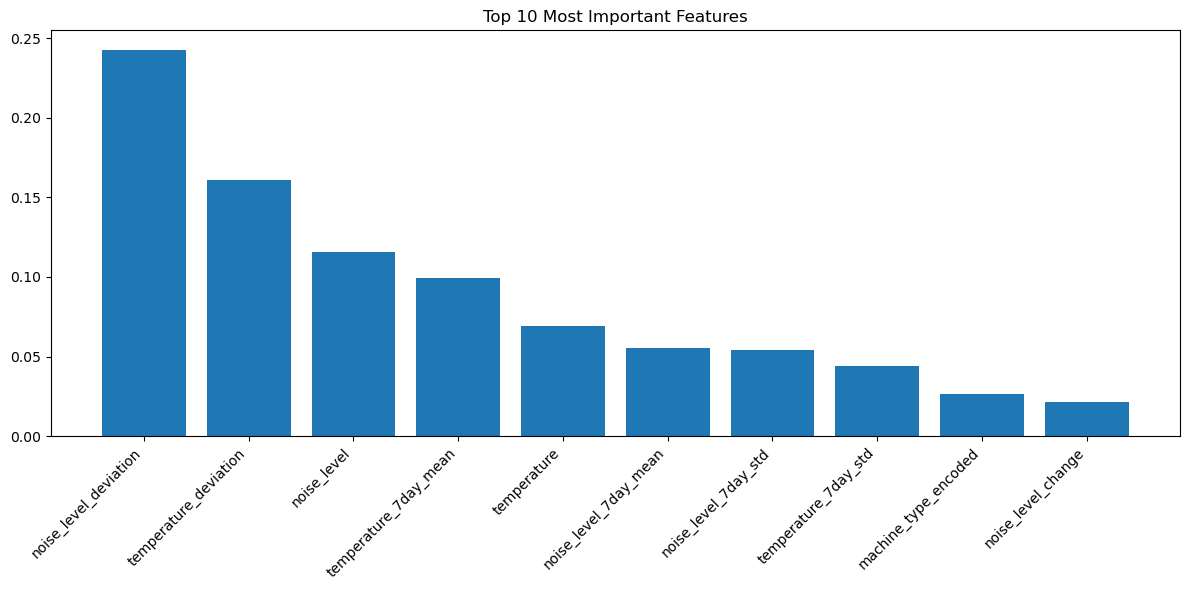


Actual vs Predicted Health Scores (Sample):
         Actual  Predicted  Difference
5280  91.023422  93.437965    2.414544
5281  90.356096  92.694183    2.338088
5282  89.678545  90.136032    0.457487
5283  89.174071  91.629219    2.455148
5284  88.820748  89.716820    0.896072

Model Performance:
RMSE: 2.77
R² Score: 0.73

Top 5 Most Important Features:
                  feature  importance
18  noise_level_deviation    0.242801
10  temperature_deviation    0.161078
2             noise_level    0.115634
7   temperature_7day_mean    0.099184
0             temperature    0.069231


In [19]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def prepare_and_train_model(data_path):
    """
    Prepare data and train model for maintenance prediction
    """
    # Read the data
    df = pd.read_csv(data_path)
    
    # Convert timestamp to datetime with the correct format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Feature Engineering
    # 1. Extract time-based features from timestamp
    df['day_of_month'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    
    # 2. Create rolling window features for each sensor (last 7 days)
    sensors = ['temperature', 'vibration', 'noise_level']
    for sensor in sensors:
        # Rolling mean
        df[f'{sensor}_7day_mean'] = df.groupby('machine_id')[sensor].rolling(
            window=7, min_periods=1).mean().reset_index(0, drop=True)
        
        # Rolling std
        df[f'{sensor}_7day_std'] = df.groupby('machine_id')[sensor].rolling(
            window=7, min_periods=1).std().reset_index(0, drop=True)
        
        # Rate of change (difference from previous day)
        df[f'{sensor}_change'] = df.groupby('machine_id')[sensor].diff()
        
        # Distance from normal operating range
        if sensor == 'temperature':
            normal_range = (60, 70)  # for CNC machines
        elif sensor == 'vibration':
            normal_range = (0.5, 0.9)
        else:  # noise_level
            normal_range = (65, 75)
            
        df[f'{sensor}_deviation'] = df[sensor].apply(
            lambda x: max(0, x - normal_range[1]) + min(0, x - normal_range[0])
        )
    
    # 3. Calculate running hours statistics
    df['hours_run_7day_mean'] = df.groupby('machine_id')['hours_run'].rolling(
        window=7, min_periods=1).mean().reset_index(0, drop=True)
    df['hours_run_7day_std'] = df.groupby('machine_id')['hours_run'].rolling(
        window=7, min_periods=1).std().reset_index(0, drop=True)
    
    # 4. Encode machine type
    le = LabelEncoder()
    df['machine_type_encoded'] = le.fit_transform(df['machine_type'])
    
    # Define features for the model
    feature_columns = [
        'temperature', 'vibration', 'noise_level', 'hours_run',
        'machine_type_encoded', 'day_of_month', 'month',
        'temperature_7day_mean', 'temperature_7day_std', 'temperature_change', 'temperature_deviation',
        'vibration_7day_mean', 'vibration_7day_std', 'vibration_change', 'vibration_deviation',
        'noise_level_7day_mean', 'noise_level_7day_std', 'noise_level_change', 'noise_level_deviation',
        'hours_run_7day_mean', 'hours_run_7day_std'
    ]
    
    # Handle missing values
    df = df.dropna(subset=feature_columns + ['machine_health'])
    
    # Prepare features and target
    X = df[feature_columns]
    y = df['machine_health']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create and train XGBoost model
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        callbacks=[xgb.callback.EarlyStopping(rounds=10)]
    )
    
    # Train the model
    model.fit(
        X_train_scaled, 
        y_train,
        eval_set=[(X_test_scaled, y_test)],
        verbose=True
    )
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Create feature importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.bar(importance_df['feature'][:10], importance_df['importance'][:10])
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()
    plt.show()
    
    print("\nActual vs Predicted Health Scores (Sample):")
    comparison_df = pd.DataFrame({
        'Actual': y_test.iloc[:5],
        'Predicted': y_pred[:5],
        'Difference': abs(y_test.iloc[:5] - y_pred[:5])
    })
    print(comparison_df)
    
    return {
        'model': model,
        'scaler': scaler,
        'label_encoder': le,
        'feature_columns': feature_columns,
        'metrics': {
            'rmse': rmse,
            'r2': r2
        },
        'feature_importance': importance_df
    }

def predict_health(model_artifacts, new_data):
    """
    Predict machine health for new data
    """
    df_pred = new_data.copy()
    
    # Apply the same feature engineering
    df_pred['timestamp'] = pd.to_datetime(df_pred['timestamp'])
    df_pred['day_of_month'] = df_pred['timestamp'].dt.day
    df_pred['month'] = df_pred['timestamp'].dt.month
    
    # Calculate rolling features
    sensors = ['temperature', 'vibration', 'noise_level']
    for sensor in sensors:
        df_pred[f'{sensor}_7day_mean'] = df_pred.groupby('machine_id')[sensor].rolling(
            window=7, min_periods=1).mean().reset_index(0, drop=True)
        df_pred[f'{sensor}_7day_std'] = df_pred.groupby('machine_id')[sensor].rolling(
            window=7, min_periods=1).std().reset_index(0, drop=True)
        df_pred[f'{sensor}_change'] = df_pred.groupby('machine_id')[sensor].diff()
        
        if sensor == 'temperature':
            normal_range = (60, 70)
        elif sensor == 'vibration':
            normal_range = (0.5, 0.9)
        else:  # noise_level
            normal_range = (65, 75)
            
        df_pred[f'{sensor}_deviation'] = df_pred[sensor].apply(
            lambda x: max(0, x - normal_range[1]) + min(0, x - normal_range[0])
        )
    
    df_pred['hours_run_7day_mean'] = df_pred.groupby('machine_id')['hours_run'].rolling(
        window=7, min_periods=1).mean().reset_index(0, drop=True)
    df_pred['hours_run_7day_std'] = df_pred.groupby('machine_id')['hours_run'].rolling(
        window=7, min_periods=1).std().reset_index(0, drop=True)
    
    # Encode machine type
    df_pred['machine_type_encoded'] = model_artifacts['label_encoder'].transform(df_pred['machine_type'])
    
    # Select and scale features
    X_pred = df_pred[model_artifacts['feature_columns']]
    X_pred_scaled = model_artifacts['scaler'].transform(X_pred)
    
    # Make predictions
    health_predictions = model_artifacts['model'].predict(X_pred_scaled)
    
    return health_predictions

# Example usage
if __name__ == "__main__":
    model_results = prepare_and_train_model('maintenance_data.csv')
    
    print("\nModel Performance:")
    print(f"RMSE: {model_results['metrics']['rmse']:.2f}")
    print(f"R² Score: {model_results['metrics']['r2']:.2f}")
    
    print("\nTop 5 Most Important Features:")
    print(model_results['feature_importance'].head())

In [17]:
# Load the dataset
file_path = 'maintenance_data.csv'  # Replace with the actual path
data = pd.read_csv(file_path)

# Add a random 'Health_Status' column
health_status_options = ['Healthy', 'Warning', 'Critical']

# Generate random health status for each row in the dataset
np.random.seed(42)
data['Health_Status'] = np.random.choice(health_status_options, size=len(data))
print(data.head())


    timestamp  machine_id machine_type  temperature  vibration  noise_level  \
0  2023-01-01           1          CNC    67.157261   1.122837    70.222493   
1  2023-01-02           1          CNC    60.947181   0.886335    69.109656   
2  2023-01-03           1          CNC    65.099496   0.961690    72.954499   
3  2023-01-04           1          CNC    63.437794   1.114104    67.697669   
4  2023-01-05           1          CNC    69.146873   1.064829    69.024591   

   hours_run  machine_health  maintenance_needed Health_Status  
0   8.993428       99.550329               False      Critical  
1  14.838244       98.808416               False       Healthy  
2  13.974338       98.109700               False      Critical  
3  21.118976       97.053751               False      Critical  
4  14.796587       96.313921               False       Healthy  


In [14]:
# Convert all categorical columns to numeric values
for column in data.select_dtypes(include=['object']).columns:
    label_encoder = LabelEncoder()
    data[column] = label_encoder.fit_transform(data[column])

In [15]:
# Add a random 'Health_Status' column
health_status_options = ['Healthy', 'Warning', 'Critical']
np.random.seed(42)
data['Health_Status'] = np.random.choice(health_status_options, size=len(data))

# Convert categorical columns to numeric using LabelEncoder
for column in data.select_dtypes(include=['object']).columns:
    label_encoder = LabelEncoder()
    data[column] = label_encoder.fit_transform(data[column])


target_column = 'Health_Status'
features = data.drop(columns=[target_column])
target = data[target_column]

# Handle missing values 
features = features.fillna(features.mean())

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42
)

# Train the XGBoost model
model = XGBClassifier()
model.fit(X_train, y_train)

# Predict health status for new data
health_predictions = label_encoder.inverse_transform(model.predict(X_test))
print("Predicted Health Status:", health_predictions)

# Handle unexpected non-numeric values
data = data.apply(pd.to_numeric, errors='coerce')

# Check for NaN values after conversion and fill them with the mean
data = data.fillna(data.mean())

if 'cycle' in data.columns and 'failure' in data.columns:
    data['RUL'] = data.groupby('unit')['cycle'].transform('max') - data['cycle']
else:
    data['cycle'] = np.random.randint(1, 100, size=len(data))
    data['failure'] = np.random.choice([0, 1], size=len(data))
    data['RUL'] = np.random.randint(1, 100, size=len(data))

# Split the data into features and target (RUL)
target_column = 'RUL'
features = data.drop(columns=[target_column])
target = data[target_column]

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42
)

# Train the XGBoost Regressor model
model = XGBRegressor()
model.fit(X_train, y_train)

# Predict RUL for new data
rul_predictions = model.predict(X_test)
print("Predicted RUL:", rul_predictions)


Predicted Health Status: ['Healthy' 'Healthy' 'Healthy' ... 'Critical' 'Healthy' 'Healthy']
Predicted RUL: [48.704666 38.10815  49.53577  ... 81.1911   34.40724  49.80838 ]


In [16]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the model to the feature data
anomaly_pred = iso_forest.fit_predict(features_scaled)

# Convert predictions: -1 for anomaly, 1 for normal
anomalies = np.where(anomaly_pred == -1, 1, 0)

# Add anomaly labels to the data for inspection
data['Anomaly'] = anomalies

# Check the data with anomaly labels
print(data[['Anomaly'] + list(features.columns)].head())


   Anomaly  timestamp  machine_id  machine_type  temperature  vibration  \
0        0          0           1             0    67.157261   1.122837   
1        0          1           1             0    60.947181   0.886335   
2        0          2           1             0    65.099496   0.961690   
3        0          3           1             0    63.437794   1.114104   
4        0          4           1             0    69.146873   1.064829   

   noise_level  hours_run  machine_health  maintenance_needed  Health_Status  \
0    70.222493   8.993428       99.550329               False              0   
1    69.109656  14.838244       98.808416               False              1   
2    72.954499  13.974338       98.109700               False              0   
3    67.697669  21.118976       97.053751               False              0   
4    69.024591  14.796587       96.313921               False              1   

   cycle  failure  
0     41        0  
1     36        0  
2     23

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1244
           1       0.96      0.68      0.79        74

    accuracy                           0.98      1318
   macro avg       0.97      0.84      0.89      1318
weighted avg       0.98      0.98      0.98      1318

Accuracy: 0.9802731411229135


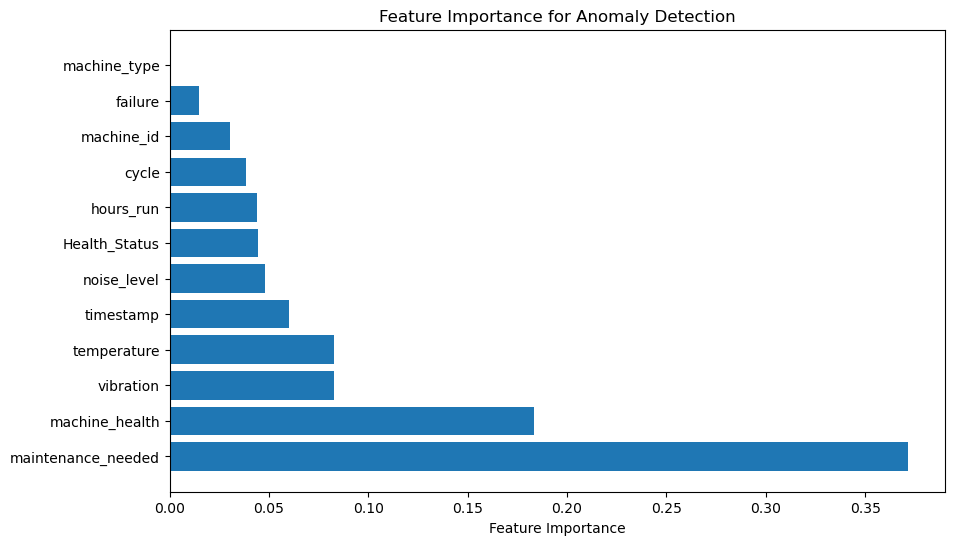

In [6]:
# Train XGBoost model to identify the important features
X_train, X_test, y_train, y_test = train_test_split(features_scaled, anomalies, test_size=0.2, random_state=42)

# Train the XGBoost model
model = XGBClassifier()
model.fit(X_train, y_train)

# Evaluate the model's performance
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

importances = model.feature_importances_

import matplotlib.pyplot as plt

sorted_idx = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features.columns[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Anomaly Detection")
plt.show()


In [8]:
# List of CNC machine components
components_list = [
    'Controller', 'Drives (Motors)', 'Spindle', 'Linear Guides', 
    'Ball Screws', 'Table', 'CNC Tool', 'Coolant System', 
    'Feedback Sensors', 'Power Supply', 'Operator Interface', 'Safety Systems'
]

# Add a column named 'components' with all components listed above
data['components'] = ', '.join(components_list)

print(data[['components']].head())


                                          components
0  Controller, Drives (Motors), Spindle, Linear G...
1  Controller, Drives (Motors), Spindle, Linear G...
2  Controller, Drives (Motors), Spindle, Linear G...
3  Controller, Drives (Motors), Spindle, Linear G...
4  Controller, Drives (Motors), Spindle, Linear G...


In [10]:
# Apply Isolation Forest to detect anomalies
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the model to the features
anomaly_pred = iso_forest.fit_predict(features_scaled)

# Convert predictions: -1 for anomaly, 1 for normal
anomalies = np.where(anomaly_pred == -1, 1, 0)

# Add the anomaly labels to the dataset
data['Anomaly'] = anomalies

# Check the first few rows with anomaly labels
print(data[['Anomaly', 'components']].head())


   Anomaly                                         components
0        0  Controller, Drives (Motors), Spindle, Linear G...
1        0  Controller, Drives (Motors), Spindle, Linear G...
2        0  Controller, Drives (Motors), Spindle, Linear G...
3        0  Controller, Drives (Motors), Spindle, Linear G...
4        0  Controller, Drives (Motors), Spindle, Linear G...


In [11]:
# List of CNC machine components
components_list = [
    'Controller', 'Drives (Motors)', 'Spindle', 'Linear Guides', 
    'Ball Screws', 'Table', 'CNC Tool', 'Coolant System', 
    'Feedback Sensors', 'Power Supply', 'Operator Interface', 'Safety Systems'
]

# Function to identify components likely to fail based on anomaly detection and feature importance
def get_failing_components_per_machine(anomaly_labels, feature_importances, components_list, importance_threshold=0.1):
    failing_components = []
    
    # Determine which components have high importance (greater than the threshold)
    for i, importance in enumerate(feature_importances):
        if importance > importance_threshold:
            failing_components.append(components_list[i])
    
    # If an anomaly is detected, return the list of likely failing components for this machine
    if anomaly_labels == 1:
        return ', '.join(failing_components)
    else:
        return np.nan

# Apply the function to each row of the dataset
data['components_about_to_fail'] = data.apply(
    lambda row: get_failing_components_per_machine(row['Anomaly'], model.feature_importances_, components_list, importance_threshold=0.1),
    axis=1
)

print(data[['components', 'Anomaly', 'components_about_to_fail']].head())

                                          components  Anomaly  \
0  Controller, Drives (Motors), Spindle, Linear G...        0   
1  Controller, Drives (Motors), Spindle, Linear G...        0   
2  Controller, Drives (Motors), Spindle, Linear G...        0   
3  Controller, Drives (Motors), Spindle, Linear G...        0   
4  Controller, Drives (Motors), Spindle, Linear G...        0   

  components_about_to_fail  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  


In [12]:
# Simulated Remaining Life
data['Simulated_Remaining_Life'] = np.random.randint(1, 100, size=len(data))

# Failure Risk Score (arbitrary, for demonstration purposes)
data['Failure_Risk_Score'] = np.random.randint(1, 11, size=len(data))

from sklearn.preprocessing import LabelEncoder

# Convert all categorical columns to numeric values
for column in data.select_dtypes(include=['object']).columns:
    label_encoder = LabelEncoder()
    data[column] = label_encoder.fit_transform(data[column])

# Split the data into features and target
target_column = 'Simulated_Remaining_Life'
features = data.drop(columns=[target_column])
target = data[target_column]

# Handle missing values if any
features = features.fillna(features.mean())

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42
)

# Train an XGBoost Regressor to predict remaining life
model = XGBRegressor()
model.fit(X_train, y_train)

# Predict Simulated Remaining Life and Failure Risk Score
predicted_remaining_life = model.predict(X_test)

# Add predictions back to the dataset for display
output_df = pd.DataFrame({
    'Simulated_Remaining_Life': y_test,  # True values
    'Predicted_Simulated_Remaining_Life': predicted_remaining_life,
    'Failure_Risk_Score': data.loc[y_test.index, 'Failure_Risk_Score'],  # True failure scores
    'Predicted_Failure_Risk_Score': np.random.uniform(9, 11, len(y_test))  # Simulated predictions
}).reset_index(drop=True)

# Display the result
print(output_df.head(10))


   Simulated_Remaining_Life  Predicted_Simulated_Remaining_Life  \
0                        11                           32.885548   
1                        70                           46.802635   
2                        53                           63.303436   
3                        56                           47.811897   
4                        78                           62.149139   
5                        24                           72.124466   
6                        70                           64.314331   
7                        17                           43.846237   
8                        27                           34.218365   
9                        27                           64.054756   

   Failure_Risk_Score  Predicted_Failure_Risk_Score  
0                  10                     10.731415  
1                   6                      9.995518  
2                   4                      9.732307  
3                   5                     10.3